# MNIST example with 3-conv. layer network

This example demonstrates the usage of `LRFinder` with a 3-conv. layer network on the MNIST dataset.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [2]:
import sys
sys.path.insert(0, "../../..")

## Loading MNIST

In [3]:
mnist_pwd = "../data"
batch_size= 256

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = MNIST(mnist_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = MNIST(mnist_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

## Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [7]:
from ignite.engine import create_supervised_trainer
from ignite.contrib.handlers import LRFinder

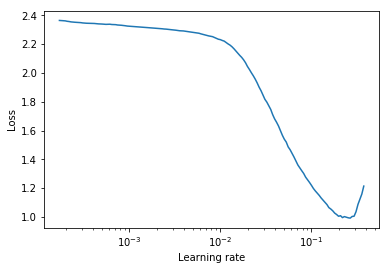

In [8]:
trainer = create_supervised_trainer(model, optimizer, criterion, device="cuda")

lr_finder = LRFinder(model, optimizer, diverge_th=1.5) 

with lr_finder.attach(trainer):
    trainer.run(trainloader)

lr_finder.plot()

In [9]:
lr_finder.lr_suggestion()

0.03753773681925604

In [10]:
for k, v in lr_finder.get_results().items():
    print(k, len(v))

lr 173
loss 173
